## Restricted Boltzmann Machine (RBM)
A [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine) is a generative stochastic artificial neural network that can learn a probability distribution over its set of inputs. 

A standard RBM has following diagram
<img src="../assets/rbm-diagram.png" alt="rbm-diagram" style="width: 40%; height: 40%">

where we denote
* $v\in\mathbb{R}^D$ is visible units
* $h\in\mathbb{R}^H$ is hidden units

And $v,h$ takes binary value (0,1), then it defines an energy function (similar as Hopfield network)
$$
E(v,h) = -a^Tv -b^Th - v^TWh
$$
which allows us to model the joint-distribution $(v,h)$ in term of the energy function i.e
$$
P(v,h) = \frac{1}{Z}e^{-E(v,h)}
$$
where $Z$ is normalized constant i.e
$$
Z = \sum_{v,h}e^{-E(v,h)}
$$

The above diagram is a bipartite graph which allows to define conditional probability 
$$
\begin{array}{rl}
P(v|h) &= \prod_{i=1}^DP(v_i|h)\\
P(h|v) &= \prod_{j=1}^HP(h_j|v)
\end{array}
$$
where individual probability is given by
$$
\begin{array}{rl}
P(v_i=1|h) &= \sigma\left(a_i + \sum_{j=1}^{H}w_{i,j}h_j\right)\\
P(h_j=1|v) &= \sigma\left(b_j + \sum_{i=1}^Dw_{i,j}v_i\right)
\end{array}
$$

### RBM task
In this note, we look at the following task
* given a set of unlabelled dataset $\left\{v^{(i)}\right\}_{i=1}^n$
* given a configuration of RMB e.g number of hidden units $H$

The goal is to learn $a$, $b$ and $W$ that model the joint-distribution directly from dataset $\left\{v^{(i)}\right\}_{i=1}^n$ i.e that maximize the sum of log-likelihood
$$
\sum_{i=1}^n\log\left(P(v^{(i)})\right)
$$
where 
$$
P(v) = \sum_{h}P(v,h)=\frac{1}{Z}\sum_{h}e^{-E(v,h)}
$$

### How to train RBM
The learning for RBM is difficult since computation of $Z$ is exponentially hard, however we have the following interesting fact
$$
\begin{array}{rl}
\frac{\partial \log P(v)}{\partial w_{i,j}} &= <v_i,h_j>_{data} - <v_i,h_j>_{model}\\
\frac{\partial \log P(v)}{\partial a_i} &= <v_i>_{data} - <v_i>_{model} \\
\frac{\partial \log P(v)}{\partial b_j} &= <h_j>_{data} - <h_j>_{model}
\end{array}
$$
where
* $<v_i, h_j>_{data}$ is expected value of the product when $v$ is clamped on data (i.e $v_i$ is taken from training dataset)
* $<v_i, h_j>_{model}$ is expected value of the product when $v,h$ is generated by model
* $<v_i>_{data}, <h_j>_{data}, <v_i>_{model}, <h_j>_{model}$ are defined similarly

Now let's look at how we compute $<v_i,h_j>_{data}$ and $<v_i,h_j>_{model}$, it's done via two phases
* **positive phase**: clamp a datavector on the visible units, then we sample $h$ and compute the average $<v,h>$
* **negative phase**: keep a set of fantasy particles $v$ where each particle has a value that is a global configuration, then we sample $h$ and compute the average $<v,h>$

To illustrate the process, we show the following diagram is taken from G. Hinton's course (NN)
<img src="../assets/rbm-pos-neg.png" alt="rbm-pos-neg" style="width: 60%; height: 50%">

and the update rule for $W$
$$
\Delta w_{i,j} = \epsilon\left( <v_i,h_j>^0 - <v_i,h_j>^\infty \right)
$$
This is actually based on Markov Chain Monte Carlo (MCMC) and Gibbs sampling. However this's still not efficient enough. 
 
Fortunately, G. Hinton introduces a very fast learning algorithm so called **Constrative Divergence Learning** where we can use a short cut
<img src="../assets/rbm-cd-learning.png" alt="rbm-cd-learning" style="width: 60%; height: 50%">
we denote 
$$
CD_1 = <v_i,h_j>^0 - <v_i,h_j>^1
$$
we can similarly define $CD_t = <v_i,h_j>^0 - <v_i,h_j>^t$. One can see that the learning doesn't use the correct gradient of the log-likelihood, as suggested by G. Hinton, we can use the following process
* start with small weight $w_{i,j}$ and we use $CD_1$
* once the weights grow (after some number of iterations), we can use $CD_3$, then $CD_{10}$

## Implement RBM
It's time to implement RBM for the above task, we will consider MNIST dataset for this task, then later we go through some RBM's application.

First we load needed modules

In [1]:
import numpy as np
import sys

# add parent to search path
if '..' not in sys.path:
    sys.path.insert(0, '..')

    
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

from helpers import rbm

Now let's download MNIST dataset

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('.', one_hot=True, reshape=False)

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


Let's inspect the data a bit

number of training point: 55000
shape of training data:   (55000, 28, 28, 1)
max of training point: 1.0
min of training point: 0.0
labels histogram


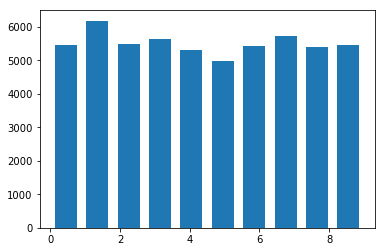

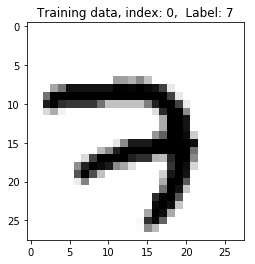

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

print('number of training point:', mnist.train.num_examples)
print('shape of training data:  ', mnist.train.images.shape)
print('max of training point:', np.max(mnist.train.images))
print('min of training point:', np.min(mnist.train.images))
labels = np.argwhere(mnist.train.labels==1)[:,1]
hist, bins = np.histogram(labels, bins=10)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
print('labels histogram')
plt.figure(1)
_ = plt.bar(center, hist, align='center', width=width)

def draw_digit(image, label, index):
    plt.title('Training data, index: {},  Label: {}'.format(index, label))
    plt.imshow(image, cmap='gray_r')
    plt.show()

# Function for displaying a training image by it's index in the MNIST set
def show_digit(dataset, labels, index):
    label = labels[index].argmax(axis=0)
    # Reshape 784 array into 28x28 image
    image = dataset[index].reshape([28,28])    
    draw_digit(image, label, index)

plt.figure(2)
show_digit(mnist.train.images, mnist.train.labels, 0)   

# let reshape data
train_X = np.reshape(mnist.train.images,      [-1, 28*28])
valid_X = np.reshape(mnist.validation.images, [-1, 28*28])

Let's train MNIST using RBM

In [34]:
num_hiddens = 100
rbm_model = rbm.RBMachine(train_X.shape[1], num_hiddens)

epochs = 20
batch_size = 128
learning_rate = 1e-1
rbm_model.train(train_X, valid_X, epochs, batch_size, learning_rate, cd_steps=1, use_pcd = False)

Epoch (1/20)Step   400 Loss 0.0786 

Epoch (2/20)Step   850 Loss 0.0695 

Epoch (3/20)Step  1250 Loss 0.0650 

Epoch (4/20)Step  1700 Loss 0.0621 

Epoch (5/20)Step  2100 Loss 0.0603 

Epoch (6/20)Step  2550 Loss 0.0587 

Epoch (7/20)Step  3000 Loss 0.0575 

Epoch (8/20)Step  3400 Loss 0.0561 

Epoch (9/20)Step  3850 Loss 0.0552 

Epoch (10/20)Step  4250 Loss 0.0544 

Epoch (11/20)Step  4700 Loss 0.0534 

Epoch (12/20)Step  5100 Loss 0.0529 

Epoch (13/20)Step  5550 Loss 0.0522 

Epoch (14/20)Step  6000 Loss 0.0516 

Epoch (15/20)Step  6400 Loss 0.0512 

Epoch (16/20)Step  6850 Loss 0.0506 

Epoch (17/20)Step  7250 Loss 0.0504 

Epoch (18/20)Step  7700 Loss 0.0499 

Epoch (19/20)Step  8150 Loss 0.0496 

Epoch (20/20)Step  8550 Loss 0.0491 




### Visualize RBM re-construction phase
We can use RBM to re-construct the input from hidden layer

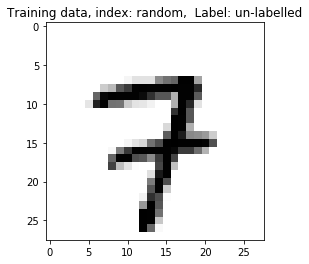

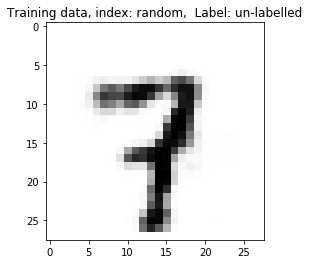

In [58]:
i = np.random.randint(valid_X.shape[0])
v0 = valid_X[i]

v1_probs, v1 = rbm_model.sample(v0, num_gibbs_step=1)

plt.figure(1)
draw_digit(np.reshape(v0,[28,28]), 'un-labelled', 'random')
plt.figure(2)
draw_digit(np.reshape(v1_probs,[28,28]), 'un-labelled', 'random')

### Visualize RBM as generative model

Let's try using Gibbs sampling
$$
\begin{array}{rcl}
v_0 & =&\text{randomly selected from validation-set or test-set}\\
v_i & =& \mathrm{gibbs}_{sampling}(v_{i-1})
\end{array}
$$
then for $n$ big enough we have
$$
v_n \sim P(v)
$$

Let's try with $n=500$ Gibbs steps

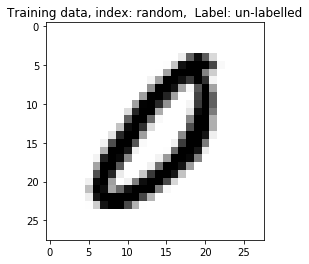

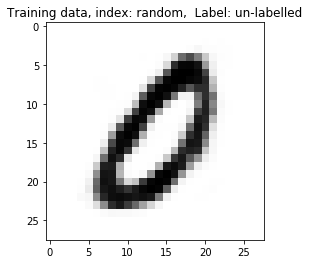

In [49]:
i = np.random.randint(valid_X.shape[0])
v0 = valid_X[i]
v_probs, v = rbm_model.sample(v0, num_gibbs_step=500)
plt.figure(1)
draw_digit(np.reshape(v0,[28,28]), 'un-labelled', 'random')
plt.figure(2)
draw_digit(np.reshape(v_probs,[28,28]), 'un-labelled', 'random')

## RBM applications

We can see the re-construction is not very clear but still keeps similar shape/constrat. Based on this properties, RBM can be applied in
* Dimension reduction: as seen above we can use 100 hidden units as a compression of input image (756) and we can re-construct the input from hidden unit.
* Feature learning: we can use 100 hidden units as features for example in classification e.g we use the hidden units in MNIST recognition tasks to see if we obtain a good accuracy.

### MNIST feature learning